---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch metrics
from torchmetrics.classification import BinaryAccuracy

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# Utils
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from datetime import datetime
# import pytz
# import copy

# wandb
import wandb
wandb.login()

# sklearn
from sklearn.model_selection import GroupKFold
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gpintoruiz (aiuis). Use `wandb login --relogin` to force relogin


In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [2]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [3]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [4]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    # audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [5]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 0


### <font color='#52F17F'>**Visualización de los datos**</font>

In [6]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx], cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

In [ ]:
plot_frame_strip(complete_dataset[0][1].squeeze(0).numpy())

In [8]:
complete_dataset[0][0].squeeze(0).numpy().reshape((90, 10)).shape

(90, 10)

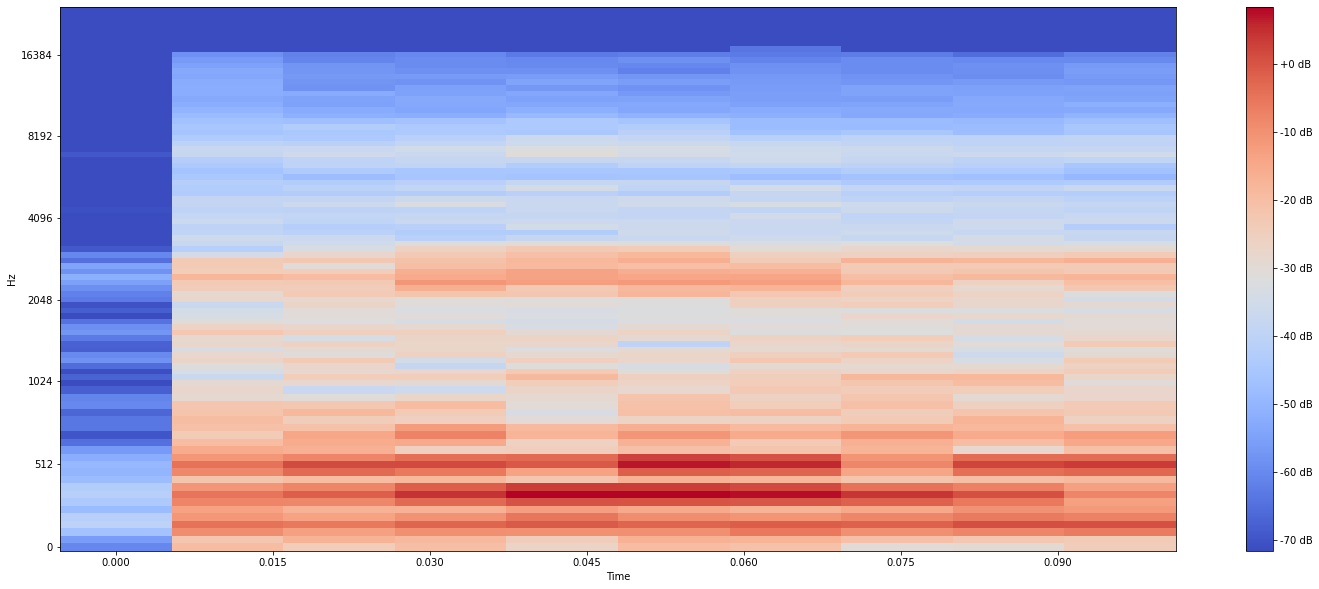

In [9]:
plt.figure(figsize=(25,10))
librosa.display.specshow(complete_dataset[0][0].squeeze(0).numpy(), y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Partición de los datos**</font>

In [6]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [7]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

### <font color='#52F17F'>**Make's for wandb**</font>

In [8]:
def get_data(train_index, test_index, data):
    full_dataset = PatientDataset(data)

    train_subset = torch.utils.data.Subset(full_dataset, train_index)
    test_subset = torch.utils.data.Subset(full_dataset, test_index)
    
    return train_subset, test_subset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

## <font color='#ECA702'>**Modelo CNN 3D**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [9]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, input_size=[1, 14, 112, 112], classes=1):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.input_size = input_size
        self.kernels = kernels

        self.final_feature_size = self.calculate_final_feature_size()
        # Adjust the fully connected layer to use the final feature size
        self.fc = nn.Linear(self.final_feature_size, classes)
        # self.fc = nn.Linear(3 * 28 * 28 * kernels[-1], classes)
    
    def calculate_final_feature_size(self):
        size_d, size_h, size_w = self.input_size[1:]
        size_d = self.conv_output_size(size_d, 5, 1, 2) // 2  # layer1 depth
        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer1 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer1 width
        
        size_d = self.conv_output_size(size_d, 5, 1, 2) // 2  # layer2 depth
        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer2 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer2 width
        
        return size_d * size_h * size_w * self.kernels[-1]

    def conv_output_size(self, size, kernel_size, stride, padding):
        return (size - kernel_size + 2 * padding) // stride + 1
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
# Test al modelo, para ver si nos entrega la salida esperada

# n_channels = 1
# n_classes = 2
# input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
# print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = ConvNet(kernels=[32, 64], classes=1)
ouput = model(input_video)
print(f"Salida: {ouput.size()}")

Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 1])


In [11]:
# Test al modelo, para ver si nos entrega la salida esperada

input_video = torch.rand([2, 1, 14, 112, 112])
# input_audio = torch.rand([2, 1, 90, 10])

# print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = ConvNet(kernels=[32, 64], classes=1)
ouput = model(input_video)
print(f"Salida: {ouput.size()}")

Entrada video: (torch.Size([2, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([2, 1])


In [12]:
targets = torch.rand([2])
print(targets.unsqueeze(1).size())

torch.Size([2, 1])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [13]:
# Hiperparametros
LEARNING_RATE = 0.005
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4

In [14]:
config = dict(
    epochs=5,
    classes=1,
    features=[32, 64],
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    optimizer = 'adam',
    dataset="ParkinsonVideo",
    architecture="CNN")

In [15]:
def make(config, train_index, test_index, data):
    # Make the data
    train, test = get_data(train_index, test_index, data)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(kernels=config.features, classes=config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

    # N-epochs to train
    epochs = config.epochs

    # Make metrics
    metric_fn = BinaryAccuracy().to(DEVICE)
    
    return model, train_loader, test_loader, criterion, optimizer, metric_fn, epochs

#### <font color='##6600CC'>**Training loop**</font>

In [16]:
def train_log(loss, accuracy, step, current):
    """ Log the metrics for the current batch into wandb

    Args:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
        step: actual step
        current: actual batch
    """

    # Where the magic happens
    # wandb.log({"step":step, "loss": loss, "accuracy": accuracy}, step=step)
    wandb.log({"step":step, "train_loss": loss, "train_accuracy": accuracy})
    print(f"train loss: {loss:.3f} accuracy: {accuracy:.3f} [after {current} batches]")

In [23]:
def train_batch(images, labels, model, optimizer, criterion, metrics_fn):
    """Train the model on a single bacth of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        criterion: a callable, the loss function.
        metrics_fn: a callable, the metrics function.

    Returns:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
    """

    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1).float())
    accuracy = metrics_fn(outputs, labels.unsqueeze(1).float())
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss, accuracy

In [18]:
def train(model, loader, criterion, optimizer, metric_fn, step):

    model.train()
    n_prints = int(len(loader)/4)
    
    # Run training and track with wandb
    for batch, (_, images, labels) in enumerate(loader):

        loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)

        # Report metrics every n_prints batch
        if batch % n_prints == n_prints-1:
            loss, current = loss.item(), batch
            # print(step)
            train_log(loss, accuracy, step, current)
            # Increment the step after logging
            step += 1
    return step

#### <font color='##6600CC'>**Evaluation loop**</font>

In [28]:
def test(model, test_loader, loss_fn, metrics_fn, epoch):
    model.eval()

    # Run the model on some test examples
    num_batches = len(test_loader)
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for _, images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            val_loss += loss_fn(outputs, labels.unsqueeze(1).float()).item()
            val_accuracy += metrics_fn(outputs, labels.unsqueeze(1).float())

    val_loss /= num_batches
    val_accuracy /= num_batches
        
    # Log the evaluation metrics at the end of batches
    wandb.log({"epoch": epoch+1, "val_accuracy": val_accuracy, "val_loss": val_loss})
    print(f"val loss: {val_loss:.3f} accuracy: {val_accuracy:.3f} [after {num_batches} batches]")
    return images

### <font color='#52F17F'>**Train and watch your metrics on wandb.ai**</font>

In [20]:
MODELS_DIR = "../models"

In [21]:
def model_pipeline(hyperparameters, train_index, test_index, data):

    # tell wandb to get started
    with wandb.init(project="ai-1-project", config=hyperparameters, dir=MODELS_DIR):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer, metric_fn, epochs = make(config,
                                                                                        train_index,
                                                                                        test_index, 
                                                                                        data)
      print(model)

      # Tell wandb to watch what the model gets up to: gradients, weights, and more!
      wandb.watch(model, criterion, log="all", log_freq=10)
      # and use them to train the model

      # Initialize the step counter 
      step = 0

      for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        step = train(model, train_loader, criterion, optimizer, metric_fn, step=step)    
        # and test its performance per epoch    
        images = test(model, test_loader, criterion, metric_fn, epoch=t)
      # Save the model in the exchangeable ONNX format
      torch.onnx.export(model, images,"model.onnx")
      wandb.save("model.onnx")

    return model

In [25]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config, train_index, test_index, data)

ConvNet(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=150528, out_features=1, bias=True)
)
Epoch 1
-------------------------------
train loss: 0.693 accuracy: 0.750 [after 57 batches]
train loss: 0.696 accuracy: 0.250 [after 115 batches]
train loss: 0.699 accuracy: 0.750 [after 173 batches]
train loss: 0.693 accuracy: 0.500 [after 231 batches]
eval loss: 0.693 accuracy: 0.506 [after 39 batches]
Epoch 2
-------------------------------
train loss: 0.684 accuracy: 0.000 [after 57 batches]
train loss: 0.693 accuracy: 0.500 [after 115 batches]
train loss: 0.778 accuracy: 0.500 [after 173 batch

accuracy,▆▃▆▅▁▅▅█████████████
epoch,▁▃▅▆█
eval_accuracy,▄█▃▁▂
eval_loss,▂▁▇▇█
loss,▇▇▇▇▇▇█▄▂▃▂▁▁▃▁▁▃▁▃▁
step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,1.0
epoch,5
eval_accuracy,0.50214
eval_loss,3.13745
loss,0.00298
